In [9]:
import numpy as np

import sys
sys.path.append('../')
import mapache

from bs4 import BeautifulSoup, NavigableString
import urllib.request

from tqdm import tqdm

import datetime

from dateutil.parser import parser

import matplotlib.pylab as plt
%matplotlib inline

A party is created from its name(s) and the party logo, that will be used to represent the party

Name: Ciudadanos
Full name: Ciudadanos - Partido de la Ciudadanía
Short name: C's


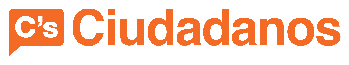

In [10]:
ciudadanos = mapache.Party('Ciudadanos',
                   'https://www.ciudadanos-cs.org/var/public/sections/page-imagen-del-partido/logo-ciudadanos.jpg',
                   short_name = 'C\'s',
                   full_name = 'Ciudadanos - Partido de la Ciudadanía')

ciudadanos.show()

# Parsing the wikipedia polls page

We recover the table with all the polls for the 2016 Spanish National elections

In [11]:
wiki = "https://en.wikipedia.org/wiki/Opinion_polling_for_the_Spanish_general_election,_2016"
page = urllib.request.urlopen(wiki)
soup = BeautifulSoup(page, "html.parser")
tables = soup.findAll("table", class_="wikitable")


## Creating the parties

The first row of the table is parsed to get the name and parties. Party logos are extracted from their wikipedia pages

In [12]:
def from_wiki_table(table):
    spanish_parties = mapache.PartySet()
    
    #Each cell except the first two and the last three corresponds to a party
    row = table.findAll("tr")[0]
    cells = row.findAll("th")    
    for c in tqdm(cells[2:-3]):
        
        #From each cell we recover the name, logo and wikipedia url of the party
        url = "http://wikipedia.org" + c.find("a").attrs["href"]
        small_logo = "http:" + c.find("img").attrs["src"]
        name = c.find("a").attrs["title"]
        
        # The party wiki page is fetched to get the full name and full logo
        page = urllib.request.urlopen(url)
        party_soup = BeautifulSoup(page, "html.parser")
        infobox = party_soup.find("table", {"class": "infobox vcard"})
        big_logo = "http:" + infobox.find("td", {"class":"logo"}).find("img").attrs["src"]
        
        # If both the English and Spanish name are present the Spanish one
        # has class "nickname", otherway it has "fn org"
        full_name = infobox.find("span", {"class":"nickname"})
        if full_name:
            full_name = full_name.text
        else:
            full_name = infobox.find("span", {"class":"fn org"}).text


        # With the data obtained from the wiki a new party is created and added
        # to the party set
        party = mapache.Party(name, big_logo,
                       # The abbreviation/short name will be created automatically  
                       # if the name provided is too long                       
                       full_name = full_name,
                       small_logo=small_logo)

        spanish_parties.add(party)
        
    return spanish_parties

In [13]:
spanish_parties = from_wiki_table(tables[0])

100%|██████████| 7/7 [00:07<00:00,  1.06s/it]



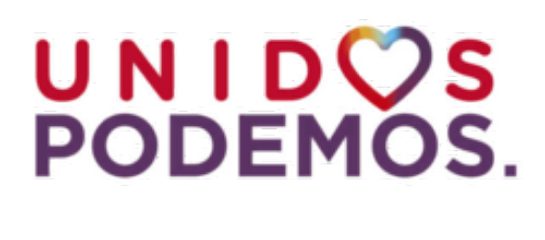
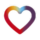
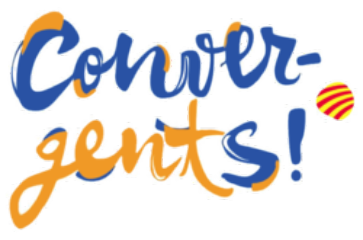
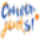
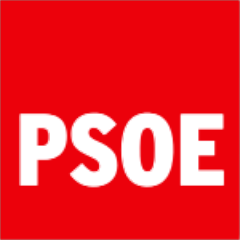
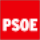
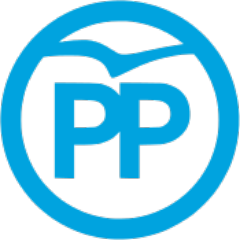
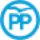
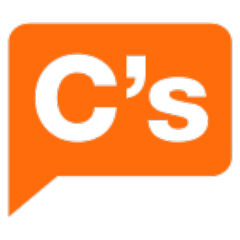
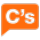
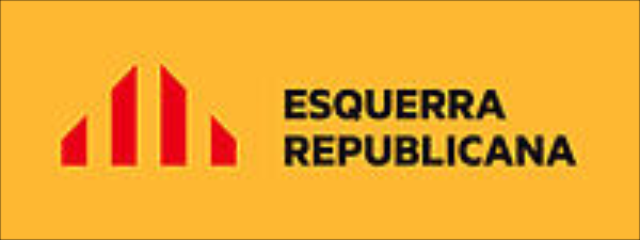
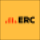
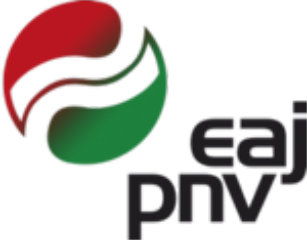
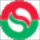

In [14]:
spanish_parties.show_parties()

In the all polls the coalition 'Unidos Podemos' was not together, we can add the parties of the coalition so they are recognized in all polls

In [15]:
spanish_parties_old = from_wiki_table(tables[1])

100%|██████████| 8/8 [00:08<00:00,  1.01it/s]



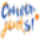
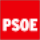
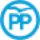
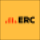
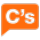
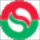
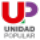
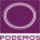

In [16]:
spanish_parties_old.show_parties(small=True)


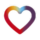
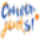
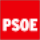
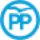
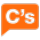
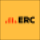
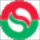

In [17]:
spanish_parties.show_parties(small=True)

Name: Podemos+allies
Full name: Podemos
Short name: POD


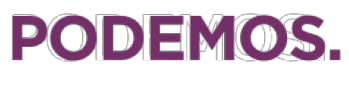

In [18]:
spanish_parties_old['POD'].show()

In [19]:
spanish_parties_old.parties

{"C'S": <mapache.core.Party at 0x7f277ed4cc88>,
 'CDC': <mapache.core.Party at 0x7f27747c87b8>,
 'ERC': <mapache.core.Party at 0x7f2774a166a0>,
 'IU-': <mapache.core.Party at 0x7f27749be0f0>,
 'PNV': <mapache.core.Party at 0x7f27746de6d8>,
 'POD': <mapache.core.Party at 0x7f2774416cc0>,
 'PP': <mapache.core.Party at 0x7f277f21d6a0>,
 'PSOE': <mapache.core.Party at 0x7f27746580b8>}

In [20]:
coalition_party_names = ['POD', 'IU-']

In [21]:
for p in coalition_party_names:
    spanish_parties['UP'].add_to_coalition(spanish_parties_old[p])

In [22]:
spanish_parties_old.parties['POD']

Name: Unidos Podemos
Full name: Unidos Podemos
Short name: UP
In this coalition:  ['Podemos+allies', 'IU-UPeC']


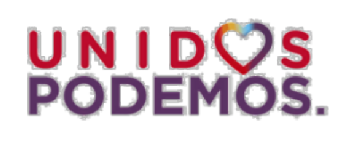

In [23]:
spanish_parties['UP'].show()

## Parsing the polls

## We parse the Wikipedia page to extract each poll and create a _PollsList_ of _Polls_

In [24]:
from dateutil.parser import parse

In [64]:
def poll_from_table(table):
    
    polls = mapache.PollsList("Encuestas")
    
    #Each cell except the first two and the last three corresponds to a party
    row = table.findAll("tr")[0]
    cells = row.findAll("th")  
    party_names = []
    
    for c in cells[2:-3]:
        name = c.find("a").attrs["title"]
        party_names.append(name)

    rows = table.findAll("tr")[2:]
    for row in tqdm(rows):
        
        cells = row.findAll("td")
        if len(cells) <= 3:
            continue
            
        pollster = cells[0].text
        err = cells[-3].text
        if err:
            err = float(err[1:].split(' ')[0])

        date = cells[1].text
        date = parse(date)            


        votes = {}
        for i, p in enumerate(cells[2: -3]):
            v = p.text
            if v:
                try:
                    v = float(v)
                except:
                    # Multiple parties in the cell, fix?
                    continue
                votes[party_names[i]] = v

        poll = mapache.Poll(votes, date, pollster, err)
                
        polls.add(poll)
        
    return polls


In [26]:
polls = poll_from_table(tables[0])

print('{0} polls loaded'.format(len(polls.polls)))

100%|██████████| 33/33 [00:00<00:00, 4963.32it/s]

33 polls loaded


In [27]:
polls.polls[2].print()

Pollster: NC Report
Date: 2016-05-27 00:00:00
Error: 2.2%  
--------------------
CDC: 1.6
PSOE: 21.3
PP: 30.5
Unidos Podemos: 24.7
C's: 14.2
ERC: 2.2
PNV: 1.1


We add the old polls as well (from a different table):

In [28]:
old_polls = poll_from_table(tables[1])

polls.add(old_polls)

print('{0} polls loaded'.format(len(old_polls.polls)))

100%|██████████| 78/78 [00:00<00:00, 3733.38it/s]

76 polls loaded


## Matching polls to parties

As it is likely that the all polls will not have the same name for a party, *mapache* can match a name to the closest party

In [29]:
name = 'ciutadans'
matched = spanish_parties.match(name)

print('\'{0}\' matched to \'{0}\', which included the names: {2}'.format(name, matched.name,
                                                                        matched.get_all_names()))



'ciutadans' matched to 'ciutadans', which included the names: ['Ciudadanos', "C's", "C'S"]


Using name matching it is possible to get all poll results of a party

In [30]:
spanish_parties.match('unidad popular')


In [31]:
old_polls.polls[1].print()

Pollster: Celeste-Tel[CV]
Date: 2016-05-06 00:00:00
Error: 3.1%  
--------------------
C's: 15.2
IU-UPeC: 5.2
PSOE: 21.7
Podemos+allies: 19.7
PP: 28.8


After matching the polls it is possible to plot them. The color corresponding to each party it automatically generated from the logo

*TODO*: Solve clashes between parties with similar colours

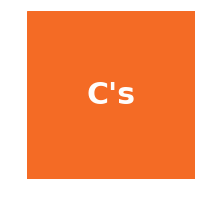

In [32]:
ciudadanos.show_color()

Simple plots can be easily created with the usual matplotlib functions. Note that the match function does not require an specific name for the party

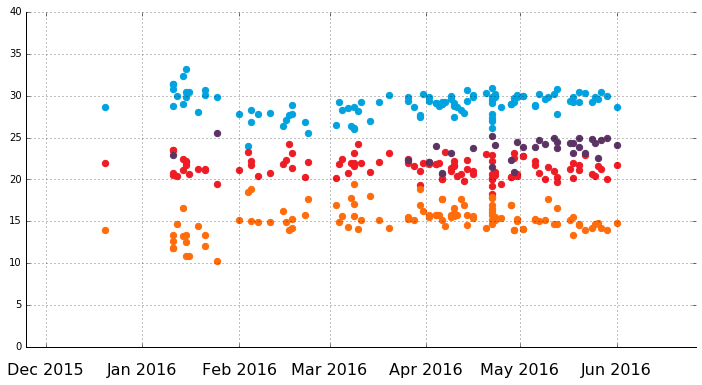

In [39]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

parties = ['pp', 'psoe', 'up', 'cs']

for k in parties:
    party_polls = polls.get_party(spanish_parties.match(k), join_coalitions=False)    
    dates = [x[0] for x in party_polls]
    votes = [x[1] for x in party_polls]           
    
    plt.scatter(dates, votes, color=spanish_parties.match(k).color, s=40)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid()
plt.ylim((0,40));


If __join_coallitions=False__, the votes of the parties being part of a coallition are not sum together, to get them we can set it to true.

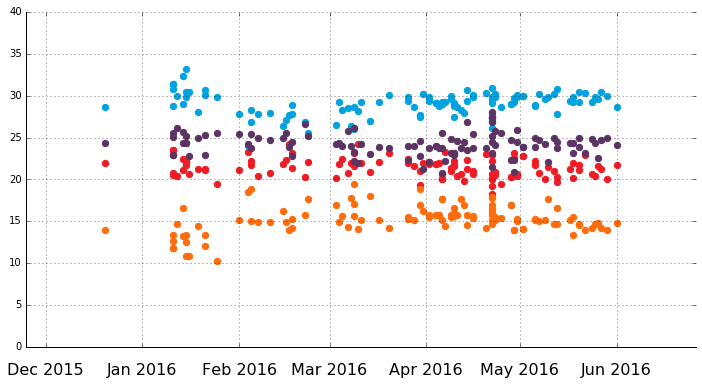

In [40]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

parties = ['pp', 'psoe', 'up', 'cs']

for k in parties:
    party_polls = polls.get_party(spanish_parties.match(k), join_coalitions=True)    
    dates = [x[0] for x in party_polls]
    votes = [x[1] for x in party_polls]           
    
    plt.scatter(dates, votes, color=spanish_parties.match(k).color, s=40)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid()
plt.ylim((0,40));


# Mapache visualization tools

We will only visualize the four main parties, to extract them from the PartyList

__TODO__: *Automatically select the top N parties* 

In [41]:
main_parties = spanish_parties.extract(['PP', 'PSOE', 'Unidos Podemos', 'Cs'])


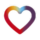
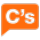
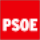
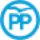

In [42]:
main_parties.show_parties(small=True)

## Visualizing a poll

In [43]:
poll=polls.polls[2]

In [44]:
elections = polls.polls[-1]

#### Bar plot
A simple plot of the parties selected (sorted by votes)

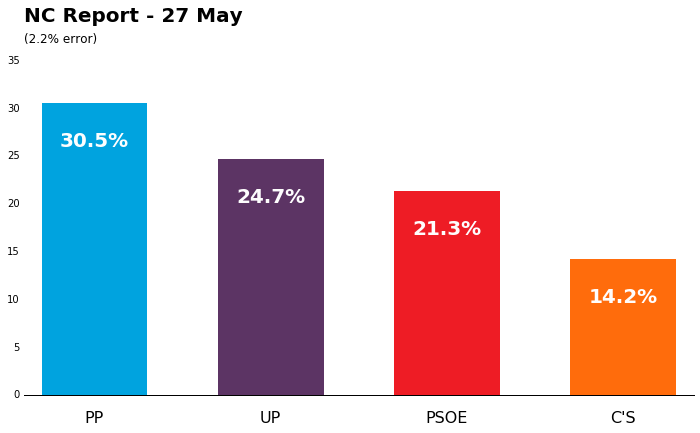

In [51]:
mapache.vis.SingleBars(poll, main_parties);

An indication of the result in a different Poll (eg. the elections) can be easily added:

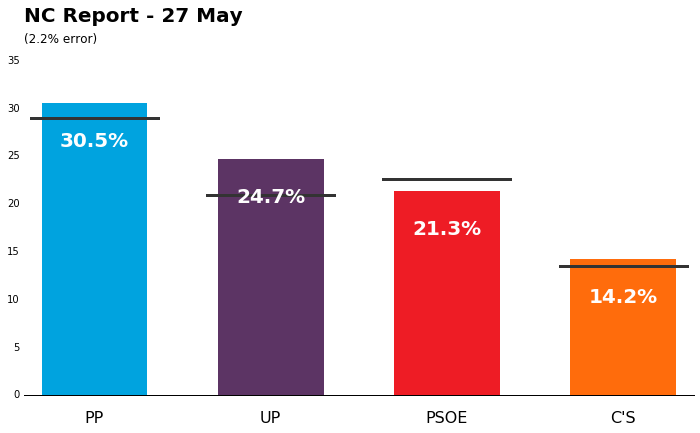

In [208]:
mapache.vis.SingleBars(poll, main_parties, elections=elections);

#Add label to the line!

#### Horizontal bar plot
#### The old good pie?

## Visualizing several polls

#### Time series 
A more complex visualization including many polls. 
In this case we will load the polls previous to the last election.

In [496]:
wiki_2015 = "https://en.wikipedia.org/wiki/Opinion_polling_for_the_Spanish_general_election,_2015"
page_2015 = urllib.request.urlopen(wiki_2015)
soup_2015 = BeautifulSoup(page_2015, "html.parser")
tables_2015 = soup_2015.findAll("table", class_="wikitable")

parties_2015 = from_wiki_table(tables_2015[0])
polls_2015 = poll_from_table(tables_2015[0])


100%|██████████| 420/420 [00:00<00:00, 3829.56it/s]



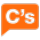
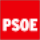
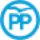
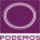

In [497]:
parties_2015 = parties_2015.extract(['PP', 'PSOE', 'Podemos', 'Cs'])
parties_2015.show_parties(small=True)

In [498]:
elections = polls_2015.polls[0]
# Modify TimeSeries to accept Poll instead of PollList!
elections20D = mapache.PollsList()
elections20D.add(elections)

del polls_2015.polls[0]

In [499]:
%matplotlib nbagg

In [510]:
ts = TimeSeries(parties_2015)

In [511]:
ts.add_column(polls_2015)
ts.add_column(elections20D)

In [512]:
%matplotlib inline

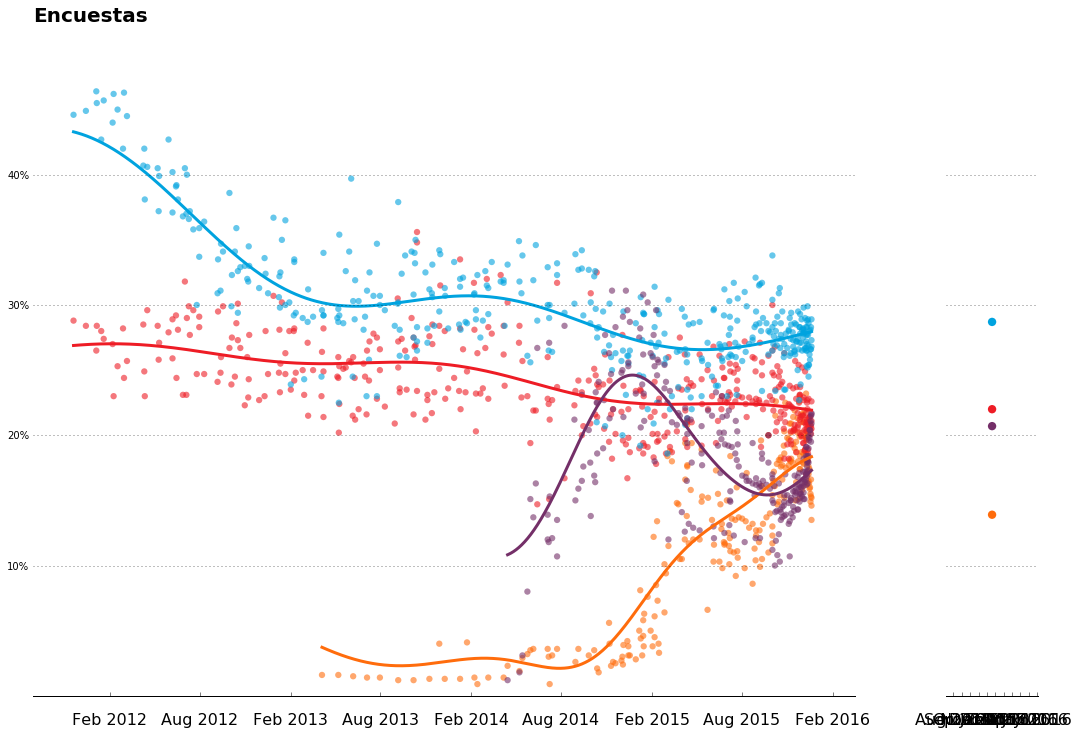

In [514]:
ts.show()

In [495]:

import matplotlib.pylab as plt
import matplotlib
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib import gridspec
from sklearn import gaussian_process
import time

def _percentage_formatter(y, _):
    """ TODO
    :param y:
    :return:
    """

    s = str(y)

    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'


class TimeSeries:
    """ TODO
    """

    def __init__(self, parties):
        """ TODO

        :param parties:
        :return:
        """
        #TODO sure?
        plt.rcParams['figure.figsize'] = (18,12)
        
        self.parties = parties
        self.columns = []
        self.__up_to_date = False
        self.__fig = None

    def add_column(self, polls, main=False):
        """ TODO

        :param polls:
        :param main:
        :return:
        """
        self.__fig = None

        self.columns.append({'polls': polls, 'main': main})

    def show(self):
        """ TODO
        :return:
        """

        if self.__fig is None:
            self.__create_fig()
        plt.show()

    def export(self, filename):
        """ TODO
        :param filename:
        :return:
        """
        # TODO
        if self.__fig is None:
            self.__create_fig()

        print(filename)

        pass

    def __create_fig(self):
        """ TODO
        :return:
        """
        self.__fig = plt.figure()

        if not self.columns:
            print('No columns have been added')
            return
            
        range_lengths = []
        for c in self.columns:
            # TODO add get_dates() to ListPolls!!
            dates = [p.date for p in c['polls'].polls]
            range_lengths.append((max(dates) - min(dates)).days)
        # range_lengths = [c['polls']['dates'][-1] - c['polls']['dates'][0] for c in self.columns]
        
        range_lengths_nonzero = [r for r in range_lengths if r != 0]
        total_length = (sum(range_lengths) / (1 - (len(self.columns) - len(range_lengths_nonzero)) * 0.1))
        range_lengths = [r / total_length if r != 0 else 0.1 for r in range_lengths]
        gs = gridspec.GridSpec(1, len(self.columns), width_ratios=range_lengths)

        for i, c in enumerate(self.columns):
            ax = plt.subplot(gs[i])
            first = False
            last = False
            if i == 0:
                first = True
            if i == len(self.columns) - 1:
                last = True
            self.__draw_column(c['polls'], ax, first, last)

        max_percentage = 0
        for i, c in enumerate(self.columns):
            for poll in c['polls'].polls:
                for name, percentages in poll.parties.items():
                    max_percentage = max(max_percentage, np.max(percentages))
                
        yticks = [tick for tick in [10, 20, 30, 40, 50, 60, 70, 80, 90] if tick < max_percentage]
        for g in gs:
            ax = plt.subplot(g)
            ax.set_yticks(yticks, minor=False)
            ax.set_ylim(0, min(max_percentage + 5, 100))

    def __draw_column(self, polls, ax, first=False, last=False):
        """ TODO

        :param polls:
        :param first:
        :param last:
        :return:
        """

        self.__fig = None

        #From type!!
        dates = [p.date for p in polls.polls]

        single = len(dates) == 1

        title_loc = 'left'
        if single:
            title_loc = 'center'

        ax.set_title(polls._name, loc=title_loc)
        
        self.__scatter(polls, self.parties, ax, single, last)
        if not single:
            self.__gp(polls, self.parties, ax)        

        ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90], minor=False)
        ax.yaxis.grid(True, which='major')
        ax.yaxis.grid(True, which='minor')
        ax.spines['top'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('bottom')
        formatter = FuncFormatter(_percentage_formatter)
        ax.get_yaxis().set_major_formatter(formatter)

        # ax.set_xlim(polls['dates'][0] - 0.5, polls['dates'][-1] + 0.5)

        if not first:
            ax.set_yticklabels([])

        if single:
#            ax.set_xticks([polls.polls[0].date], minor=False)
            pass

    def __scatter(self, polls, parties, ax, single=False, last=False):
        """ TODO
        :param single:
        :return:
        """
        
        last_date = datetime.datetime.min
        
        for party in parties.parties.values():
            polls_party = polls.get_party(party)
            
            dates = [x[0] for x in polls_party]
            votes = [x[1] for x in polls_party]           

            if single:
                ax.scatter(dates, votes, 70, c=party.color, edgecolors='none', label=u'Observations')
            else:
                ax.scatter(dates, votes, c=np.append(party.color, [0.6]), edgecolors='none', s=40,
                       label=u'Observations')
            
            last_date = max(last_date, max(dates))
        
        
        if last and False:
            #TODO add name label at the end!
             for party in parties.parties.values():
                polls_party = polls.get_party(party)           
                plt.text(last_date + 0.2, votes[-1], party.short_name,
                          color=party.color, weight='bold', verticalalignment='center')

            
    def __gp(self,polls, parties, ax):
        """ TODO

        :param x:
        :param ax:
        :param partyname:
        :return:
        """
        for party in parties.parties.values():
            polls_party = polls.get_party(party)
            
            dates = [x[0] for x in polls_party]
            votes = [x[1] for x in polls_party]           
        
            x = dates
            y = votes

            # + 0.5 - 0.5?
            
            x_dense = np.atleast_2d(np.linspace(time.mktime(x[0].timetuple()),
                                                time.mktime(x[-1].timetuple()), 1000)).T
            #x_dense = np.atleast_2d(np.linspace(x[0], x[-1], 1000)).T

            np.random.seed(1)
            gp = gaussian_process.GaussianProcess(corr='squared_exponential', theta0=1e-1,
                                                  thetaL=1e-3, thetaU=1,
                                                  random_start=100, nugget=10 - 8)
            x = [time.mktime(xi.timetuple()) for xi in x]
            gp.fit(np.reshape(x, (-1, 1)) + np.random.randn(len(x),1)*0.01, np.reshape(y,(-1, 1)))
            y_pred, mse = gp.predict(x_dense, eval_MSE=True)
            sigma = np.sqrt(mse)
            x_dense = [datetime.datetime.fromtimestamp(xi) for xi in x_dense]
            ax.plot(x_dense, y_pred, 'b-', label=u'Prediction', c=party.color, linewidth=3)
            # TODO Check and (maybe) fix?
            #  ax.fill(np.concatenate([x_dense, x_dense[::-1]]),
            #        np.concatenate([y_pred - 1.9600 * sigma,
            #                        (y_pred + 1.9600 * sigma)[::-1]]),
            #       color=np.append(party.color, [0.1]), fc='b', ec='None',
            #     label='95% confidence interval')

In [83]:
dates = [p.date for p in polls.polls]
max(dates) - min(dates) 

datetime.timedelta(1491)

In [97]:
range_lengths = []

In [100]:
dates = [p.date for p in polls.polls]
range_lengths.append((max(dates) - min(dates)).days)
# range_lengths = [c['polls']['dates'][-1] - c['polls']['dates'][0] for c in self.columns]


In [104]:
sum(range_lengths)

4473

In [85]:
min(dates)

datetime.datetime(2011, 11, 20, 0, 0)

In [ ]:
dates - 

In [56]:
# We first create a TimeSeries plot
pv = mapache.vis.TimeSeries(main_parties)

# We add a column with the  create a TimeSeries plot



AttributeError: 'module' object has no attribute 'TimeSeries'